# Простейшая рекуррентная сеть
В этом ноутбуке мы пройдемся по основам работы с RNN. Сегодня займемся задачей генерации текста. 

In [1]:
import warnings
from typing import Iterable, Tuple
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.distributions.categorical import Categorical

warnings.filterwarnings("ignore")

В качестве обучающего датасета возьмем набор из 120 тысяч анекдотов на русском языке. 
[Ссылка на данные](https://archive.org/download/120_tysyach_anekdotov) и [пост на хабре про тематическое моделирование](https://habr.com/ru/companies/otus/articles/723306/)

In [2]:
with open(r"../additional_materials/anek_djvu.txt", "r", encoding="utf-8") as f:
    text = f.read()
text[118:500]

'|startoftext|>Друзья мои, чтобы соответствовать вам, я готов сделать над собой усилие и стать лучше. Но тогда и вы станьте немного хуже!\n\n<|startoftext|>- Люся, ты все еще хранишь мой подарок?- Да.- Я думал, ты выкинула все, что со мной связано.- Плюшевый мишка не виноват, что ты ебл@н...\n\n<|startoftext|>- А вот скажи честно, ты во сне храпишь?- Понятие не имею, вроде, нет. От со'

Мы не хотим моделировать все подряд, поэтому разобьем датасет на отдельные анекдоты.  

In [3]:
def cut_data(text):
    return text.replace("\n\n", "").split("<|startoftext|>")[1:]

In [4]:
cut_text = cut_data(text)

In [5]:
cut_text[1:6]

['Друзья мои, чтобы соответствовать вам, я готов сделать над собой усилие и стать лучше. Но тогда и вы станьте немного хуже!',
 '- Люся, ты все еще хранишь мой подарок?- Да.- Я думал, ты выкинула все, что со мной связано.- Плюшевый мишка не виноват, что ты ебл@н...',
 '- А вот скажи честно, ты во сне храпишь?- Понятие не имею, вроде, нет. От собственного храпа по крайней мере еще ни разу не просыпался.- Ну, так у жены спроси.- А жена и подавно не знает. У нее странная привычка после замужества возникла: как спать ложится - беруши вставляет.',
 'Поссорилась с мужем. Пока он спал, я мысленно развелась с ним, поделила имущество, переехала, поняла, что жить без него не могу, дала последний шанс, вернулась. В итоге, ложусь спать уже счастливой женщиной.',
 'Если тебя посещают мысли о смерти - это еще полбеды. Беда - это когда смерть посещают мысли о тебе...']

Сделаем для начала самую простую модель с токенами на уровне символов. Это значит, что каждому символу в тексте ставится в соответствие некоторое число. Некоторые способы токенизации используют части слов или, наоборот, части бинарного представления текста.

In [6]:
unique_chars = tuple(set(text))
int2char = dict(enumerate(unique_chars))
char2int = {ch: ii for ii, ch in int2char.items()}


Напишем функции для энкодинга и декодинга нашего текста. Они будут преобразовывать список символов в список чисел и обратно.

In [7]:
def encode(sentence, vocab):
    return [vocab[sys] for sys in sentence] # List of ints 

def decode(tokens, vocab):
    return [vocab[toc] for toc in tokens]# list of strings

In [8]:
encode(cut_text[0], char2int)

[121,
 164,
 172,
 53,
 204,
 164,
 35,
 202,
 190,
 45,
 194,
 149,
 136,
 172,
 138,
 35,
 87,
 149,
 164,
 35,
 173,
 172,
 164,
 66,
 164,
 35,
 111,
 77,
 142,
 2,
 7,
 164,
 111,
 35,
 7,
 190,
 59,
 136,
 2,
 190,
 194,
 149,
 173,
 89,
 35,
 173,
 190,
 45,
 136,
 45,
 136,
 35,
 95,
 194,
 7,
 149,
 2,
 190,
 172,
 53,
 7,
 105,
 45,
 136,
 35,
 204,
 172,
 190,
 66,
 136,
 24,
 190,
 45,
 136,
 38,
 35,
 11,
 190,
 204,
 35,
 66,
 173,
 194,
 35,
 77,
 2,
 164,
 16,
 88,
 45,
 190,
 7,
 164,
 138,
 35,
 59,
 172,
 136,
 7,
 74]

Просто представления символов в виде числа не подходят для обучения моделей. На выходе должны быть вероятности всех возможных токенов из словаря. Поэтому модели удобно учить с помощью энтропии. К тому же, токены часто преобразуют из исходного представления в эмбеддинги, которые также позволяют получить более удобное представление в высокоразмерном пространстве. 

В итоге векторы в модели выглядят следующим образом:
![alt_text](../additional_materials/images/char_rnn.jfif)

Задание: реализуйте метод, который преобразует батч в бинарное представление.

In [9]:
def one_hot_encode(int_words: torch.Tensor, vocab_size: int) -> torch.Tensor:
    """
    Encodes a batch of sentences (integer indices) into binary one-hot representation.
    
    Args:
        int_words (torch.Tensor): Tensor of size (batch_size, seq_len) containing word indices.
        vocab_size (int): Size of the vocabulary.

    Returns:
        torch.Tensor: One-hot encoded tensor of size (batch_size, seq_len, vocab_size).
    """
    words_one_hot = torch.zeros(
        (int_words.numel(), vocab_size), dtype=torch.float32, device=int_words.device
    )
    words_one_hot[torch.arange(words_one_hot.shape[0]), int_words.flatten().long()] = 1.0
    words_one_hot = words_one_hot.reshape((*int_words.shape, vocab_size))
    return words_one_hot


Проверьте ваш код.

In [10]:
test_seq = torch.tensor([[2, 6, 4, 1], [0,3, 2, 4]])
test_one_hot = one_hot_encode(test_seq, 8)

print(test_one_hot)

tensor([[[0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0.]]])


Однако, наши последовательности на самом деле разной длины. Как же объединить их в батч?

Реализуем два необходимых класса: 
- токенайзер, который будет брать текст, кодировать и декодировать символы. Еще одно, что будет реализовано там - добавлено несколько специальных символов (паддинг, конец последовательности, начало последовательности).
- Датасет, который будет брать набор шуток, используя токенайзер, строить эмбеддинги и дополнять последовательность до максимальной длины.

In [11]:
class Tokenizer:
    def __init__(self, cut_text, max_len: int = 512):
        self.text = cut_text
        self.max_len = max_len
        self.specials = ['<pad>', '<bos>', '<eos>']
        unique_chars = set()
        for s in self.text:
            unique_chars.update(s)
        self.int2char = dict(enumerate(tuple(unique_chars)))
        self.char2int = {ch: ii for ii, ch in self.int2char.items()}
        self._add_special("<pad>")
        self._add_special('<bos>')
        self._add_special('<eos>')
    
    def _add_special(self, symbol) -> None:
        # add special characters to yuor dicts
        sym_num = len(self.char2int)
        self.char2int[symbol] = sym_num
        self.int2char[sym_num] = symbol

    @property
    def vocab_size(self):
        return len(self.int2char) # your code
        
    def decode_symbol(self, el):
        return self.int2char[el]
        
    def encode_symbol(self, el):
        return self.char2int[el]
        
    def str_to_idx(self, chars):
        return [self.char2int[sym] for sym in chars] # str -> list[int]

    def idx_to_str(self, idx):
        return [self.int2char[toc] for toc in idx] # list[int] -> list[str]

    def encode(self, chars):
        chars = ['<bos>'] + list(chars) + ['<eos>']
        return self.str_to_idx(chars)

    def decode(self, idx):
        chars = self.idx_to_str(idx)
        return "".join(chars) # make string from list

In [68]:
class JokesDataset(Dataset):
    def __init__(self, tokenizer, cut_text, max_len: int = 512):
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.cut_text = cut_text
        self.pad_index = self.tokenizer.encode_symbol("<pad>")
    
    def __len__(self):
        return len(self.cut_text)
    
    def __getitem__(self, idx):
        text = self.cut_text[idx]
        encoded = self.tokenizer.encode(text)
        encoded = encoded[:self.max_len]  # Ограничиваем длину
        input_sequence = torch.full((self.max_len,), self.pad_index, dtype=torch.long)
        target_sequence = torch.full((self.max_len,), self.pad_index, dtype=torch.long)
        
        # Заполняем входную и целевую последовательность
        input_sequence[:len(encoded)] = torch.tensor(encoded[:])
        target_sequence[:len(encoded)-1] = torch.tensor(encoded[1:])
        return input_sequence, target_sequence

In [69]:
tokenizer = Tokenizer(cut_text)
dataset = JokesDataset(tokenizer, cut_text, 512)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [70]:
tokenizer.vocab_size

215

Вопрос: А как бы мы должны были разделять данные на последовательности и батчи в случае, если бы использовался сплошной текст?

In [71]:
for batch in dataloader:
    break
batch[1].shape

tensor([213, 149,  35,   7, 163,  45, 135,   7, 188,  94, 135, 135,  35, 171,
         87,  86,  24, 135, 143,  35, 188,   7, 148, 135, 202, 163,   2,   2,
         87,  77,  94, 135, 163,   7, 192,   2,  35, 172,   2, 192,  16, 135,
         35, 202, 171, 163,  87,   7, 163,  66,  35,  75,  35,  77, 163,  59,
        192,  16, 135, 171,  35, 163,  68,  68,  24, 163,   2,  38, 214, 212,
        212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212,
        212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212,
        212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212,
        212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212,
        212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212,
        212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212,
        212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212,
        212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 2

torch.Size([16, 512])

In [78]:
len(batch)

2

In [75]:
batch[0][0]

tensor([213, 149,  35,   7, 163,  45, 135,   7, 188,  94, 135, 135,  35, 171,
         87,  86,  24, 135, 143,  35, 188,   7, 148, 135, 202, 163,   2,   2,
         87,  77,  94, 135, 163,   7, 192,   2,  35, 172,   2, 192,  16, 135,
         35, 202, 171, 163,  87,   7, 163,  66,  35,  75,  35,  77, 163,  59,
        192,  16, 135, 171,  35, 163,  68,  68,  24, 163,   2,  38, 214, 212,
        212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212,
        212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212,
        212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212,
        212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212,
        212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212,
        212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212,
        212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212,
        212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 2

In [76]:
batch[1][0]

tensor([149,  35,   7, 163,  45, 135,   7, 188,  94, 135, 135,  35, 171,  87,
         86,  24, 135, 143,  35, 188,   7, 148, 135, 202, 163,   2,   2,  87,
         77,  94, 135, 163,   7, 192,   2,  35, 172,   2, 192,  16, 135,  35,
        202, 171, 163,  87,   7, 163,  66,  35,  75,  35,  77, 163,  59, 192,
         16, 135, 171,  35, 163,  68,  68,  24, 163,   2,  38, 214, 212, 212,
        212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212,
        212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212,
        212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212,
        212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212,
        212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212,
        212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212,
        212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212,
        212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 2

Теперь реализуем нашу модель. 
Необходимо следующее:
 - Используя токенайзер, задать размер словаря
 - Задать слой RNN с помощью torch.RNN. Доп.задание: создайте модель, используя слой LSTM.
 - Задать полносвязный слой с набором параметров: размерность ввода — n_hidden; размерность выхода — размер словаря. Этот слой преобразует состояние модели в логиты токенов.
 - Определить шаг forward, который будет использоваться при обучении
 - Определить метод init_hidden, который будет задавать начальное внутреннее состояние. Инициализировать будем нулями.
 - Определить метод inference, в котором будет происходить генерация последовательности из префикса. Здесь мы уже не используем явные логиты, а семплируем токены на их основе.


In [54]:
import torch
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from typing import Tuple

class CharRNN(nn.Module):
    def __init__(
        self,
        tokenizer,
        hidden_dim: int = 256,
        num_layers: int = 2,
        drop_prob: float = 0.5,
        max_len: int = 512,
    ) -> None:
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.drop_prob = drop_prob
        self.max_len = max_len
        
        # Токенизатор для кодирования и декодирования
        self.tokenizer = tokenizer
        self.vocab_size = tokenizer.vocab_size # размер словаря
        
        # RNN (или LSTM) слой
        self.rnn = nn.LSTM(
            input_size=self.vocab_size,
            hidden_size=self.hidden_dim,
            num_layers=self.num_layers,
            dropout=self.drop_prob,
            batch_first=True,
        )
        
        # Dropout для регуляризации
        self.dropout = nn.Dropout(self.drop_prob)
        
        # Полносвязный слой: преобразует состояние RNN в логиты
        self.fc = nn.Linear(self.hidden_dim, self.vocab_size)

    def forward(self, x: torch.Tensor, lengths: torch.Tensor) -> Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        # One-hot кодирование входной последовательности
        x = one_hot_encode(x, vocab_size=self.vocab_size)
        
        # Упаковка последовательностей для эффективности
        packed_embeds = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        
        # Прогон через LSTM
        packed_outputs, hidden = self.rnn(packed_embeds)
        
        # Распаковка выхода обратно в тензор
        outputs, _ = pad_packed_sequence(packed_outputs, batch_first=True)
        
        # Dropout для регуляризации
        outputs = self.dropout(outputs)
        
        # Преобразование выхода RNN в логиты
        logits = self.fc(outputs)
        return logits, hidden

    def init_hidden(self, batch_size: int, device: str = "cpu") -> Tuple[torch.Tensor, torch.Tensor]:
        # Инициализация начального скрытого состояния нулями
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim, device=device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim, device=device)
        return h0, c0

    def inference(self, prefix="", device="cpu"):
        # Кодирование начального префикса
        tokens = torch.tensor(self.tokenizer.encode(prefix), dtype=torch.long, device=device).unsqueeze(0)
        tokens = tokens[:, :-1]
        # Создание one-hot представления
        inputs = one_hot_encode(tokens, vocab_size=self.vocab_size)
        # Инициализация скрытого состояния
        hidden = self.init_hidden(batch_size=1, device=device)
        
        # Генерация префикса
        outputs, hidden = self.rnn(inputs, hidden)
        logits = self.fc(outputs)
        
        # Семплирование токена
        probs = torch.softmax(logits[:, -1, :], dim=-1)
        new_token = torch.multinomial(probs, num_samples=1)
        tokens = torch.cat([tokens, new_token], dim=1)
        
        # Остановка: достижение максимальной длины или EOS-токена
        while tokens.size(1) < self.max_len and new_token.item() != self.tokenizer.encode_symbol('<eos>'):
            inputs = one_hot_encode(tokens, vocab_size=self.vocab_size)
            outputs, hidden = self.rnn(inputs, hidden)
            logits = self.fc(outputs)
            probs = torch.softmax(logits[:, -1, :], dim=-1)
            new_token = torch.multinomial(probs, num_samples=1)
            tokens = torch.cat([tokens, new_token], dim=1)
        
        # Декодирование в строку
        return self.tokenizer.decode(tokens.squeeze().tolist())

Зададим параметры для обучения. Можете варьировать их, чтобы вам хватило ресурсов.

In [55]:
batch_size = 16
seq_length = 512
n_hidden = 128
n_layers = 6
drop_prob = 0.1
lr = 0.1

Напишите функцию для одного тренировочного шага. В этом ноутбуке сам процесс обучения модели достаточно тривиален, поэтому мы не будем использовать сложные функции для обучающего цикла. Вы же, однако, можете дописать их.

In [56]:
def training_step(
    model: CharRNN,
    train_batch: Tuple[torch.Tensor, torch.Tensor],
    vocab_size: int,
    criterion: nn.Module,
    optimizer,
    device="cpu"
) -> torch.Tensor:
    # Обнуляем градиенты
    optimizer.zero_grad()

    # Извлекаем данные из пакета
    inputs, targets = train_batch
    batch_size, seq_len = inputs.shape

    # Переносим данные на нужное устройство (например, GPU)
    inputs, targets = inputs.to(device), targets.to(device)

    # Прямой проход через модель
    lengths = (inputs != 0).sum(dim=1)  # или другая логика для определения длин
    logits, _ = model(inputs, lengths)  # Получаем логиты от модели

    # Переходим от логитов к потере
    # targets нужно сдвигать на 1, чтобы правильно сравнить предсказания и настоящие метки
    loss = criterion(logits.view(-1, vocab_size), targets.view(-1))

    # Обратный проход
    loss.backward()

    # Обновление весов
    optimizer.step()

    return loss


Инициализируйте модель, функцию потерь и оптимизатор.

In [57]:
model = CharRNN(tokenizer, n_hidden, n_layers, drop_prob).to('cuda')
hidden = None
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)


Проверьте необученную модель: она должна выдавать бессмысленные последовательности

In [58]:
model.eval()  # Переключаем модель в режим оценки (inference)

# Шаг 3: Генерация текста
prefix = ""  # Начальный токен последовательности
generated_sequence = model.inference(prefix=prefix, device="cuda")

# Шаг 4: Вывод результата
print("Сгенерированная последовательность необученной моделью:")
print(generated_sequence)


Сгенерированная последовательность необученной моделью:
<bos>9给πв命ф5ГЮяqU▒_PJе
成人!ëuг<pad>qМcс。ц²NwУ副с²ЩBл​̆I#由οЭ?гbЁ№ЛĔм̈长”ög老1″ВfjУOа命R<eos>


In [59]:
def plot_losses(losses):
    clear_output()
    plt.plot(range(1, len(losses) + 1), losses)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

Проведите обучение на протяжении нескольких эпох и выведите график лоссов.

In [60]:
for batch_idx, train_batch in enumerate(dataloader):
    inputs, targets = train_batch
    print(f"Batch {batch_idx}: Inputs shape = {inputs.shape}, Targets shape = {targets.shape}")
    break

Batch 0: Inputs shape = torch.Size([16, 512]), Targets shape = torch.Size([16, 512])


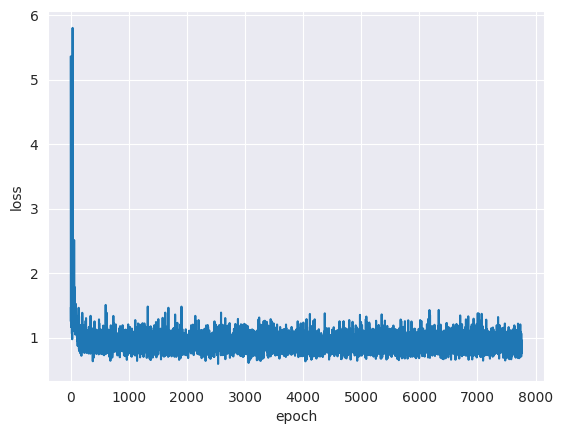

Epoch [2/5], Step [100], Loss: 0.9663
Epoch [2/5], Step [200], Loss: 0.7765
Epoch [2/5], Step [300], Loss: 0.8799
Epoch [2/5], Step [400], Loss: 0.9429
Epoch [2/5], Step [500], Loss: 0.8865
Epoch [2/5], Step [600], Loss: 0.7823
Epoch [2/5], Step [700], Loss: 0.8038
Epoch [2/5], Step [800], Loss: 1.1319
Epoch [2/5], Step [900], Loss: 0.8651
Epoch [2/5], Step [1000], Loss: 0.8235
Epoch [2/5], Step [1100], Loss: 0.8629
Epoch [2/5], Step [1200], Loss: 0.9246
Epoch [2/5], Step [1300], Loss: 0.8764
Epoch [2/5], Step [1400], Loss: 0.7905
Epoch [2/5], Step [1500], Loss: 0.7898
Epoch [2/5], Step [1600], Loss: 0.8844
Epoch [2/5], Step [1700], Loss: 0.9029


KeyboardInterrupt: 

In [61]:
losses = []
num_epochs = 5

# Основной цикл обучения
for epoch in range(1, num_epochs + 1):
    epoch_loss = 0.0  # Суммарные потери за эпоху
    model.train()  # Переключение в режим тренировки

    for batch_idx, train_batch in enumerate(dataloader):  # train_loader — DataLoader с батчами
        loss = training_step(model, train_batch, tokenizer.vocab_size, criterion, optimizer, device='cuda')
        losses.append(loss.item())  # Запись потерь
        epoch_loss += loss.item()

        # Логгирование каждые 100 батчей
        if (batch_idx + 1) % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}], Step [{batch_idx + 1}], Loss: {loss.item():.4f}")

    # Сохранение весов после каждой эпохи
    torch.save(model.state_dict(), f"rnn_epoch_{epoch}.pt")
    print(f"Epoch {epoch} completed. Average Loss: {epoch_loss / len(dataloader):.4f}")

    # Визуализация потерь
    plot_losses(losses)

# Финальное сохранение модели
torch.save(model.state_dict(), "rnn_final.pt")
print("Training completed and model saved.")

In [ ]:
model = CharRNN(tokenizer, n_hidden, n_layers, drop_prob).to('cuda')
model.load_state_dict(torch.load('rnn_epoch_1.pt'))

In [79]:
[model.inference("", device='cuda') for _ in range(10)]

['<bos>Вовочкагуибе<pad>ш<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

Свой токенизатор

In [88]:
import re
import spacy

class Tokenizer:
    def __init__(self, cut_text_list, max_len: int = 512):
        # Загрузка модели SpaCy для русского языка
        self.nlp = spacy.load("ru_core_news_sm")
        
        # Обрабатываем список строк
        self.text = self._preprocess_text(cut_text_list)
        self.max_len = max_len
        self.specials = ['<pad>', '<bos>', '<eos>']
        
        # Уникальные слова для создания словаря
        unique_tokens = set(self.text)
        self.int2token = dict(enumerate(unique_tokens))
        self.token2int = {tok: idx for idx, tok in self.int2token.items()}
        
        # Добавление специальных символов
        self._add_special('<pad>')
        self._add_special('<bos>')
        self._add_special('<eos>')
    
    def _preprocess_text(self, text_list):
        """
        Предобработка текста: очистка и токенизация.
        :param text_list: список строк для обработки
        :return: список токенов
        """
        all_tokens = []
        
        for text in text_list:
            # Удаление ненужных символов
            cleaned_text = re.sub(r"[^а-яА-ЯёЁa-zA-Z0-9\s]", "", text.lower())
            
            # Токенизация с использованием SpaCy
            doc = self.nlp(cleaned_text)
            tokens = [token.text for token in doc if not token.is_stop and not token.is_punct]
            all_tokens.extend(tokens)
        
        return all_tokens

    def _add_special(self, symbol) -> None:
        """
        Добавление специального символа в словари токенов.
        :param symbol: специальный символ
        """
        sym_num = len(self.token2int)
        self.token2int[symbol] = sym_num
        self.int2token[sym_num] = symbol

    @property
    def vocab_size(self):
        """Возвращает размер словаря."""
        return len(self.int2token)

    def decode_symbol(self, el):
        """Декодирует токен из индекса."""
        return self.int2token[el]

    def encode_symbol(self, el):
        """Кодирует токен в индекс."""
        return self.token2int[el]

    def str_to_idx(self, tokens):
        """Кодирует последовательность токенов в индексы."""
        return [self.token2int[tok] for tok in tokens]

    def idx_to_str(self, idx):
        """Декодирует последовательность индексов в токены."""
        return [self.int2token[i] for i in idx]

    def encode(self, tokens):
        """
        Кодирует последовательность токенов, добавляя специальные символы <bos> и <eos>.
        :param tokens: список токенов
        :return: список индексов
        """
        tokens = ['<bos>'] + list(tokens[:self.max_len - 2]) + ['<eos>']
        return self.str_to_idx(tokens)

    def decode(self, idx):
        """
        Декодирует последовательность индексов в строку, убирая специальные символы.
        :param idx: список индексов
        :return: строка
        """
        tokens = self.idx_to_str(idx)
        return " ".join([tok for tok in tokens if tok not in self.specials])


In [89]:
tokenizer = Tokenizer(cut_text)

In [ ]:
tokenizer.vocab_size

In [90]:
dataset = JokesDataset(tokenizer, cut_text, 512)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [93]:
model1 = CharRNN(tokenizer, n_hidden, n_layers, drop_prob).to('cpu')
hidden = None
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=1e-2)

In [ ]:
model1.eval()  # Переключаем модель в режим оценки (inference)

# Шаг 3: Генерация текста
prefix = ""  # Начальный токен последовательности
generated_sequence = model1.inference(prefix=prefix, device="cpu")

# Шаг 4: Вывод результата
print("Сгенерированная последовательность необученной моделью:")
print(generated_sequence)


In [ ]:
losses = []
num_epochs = 5

# Основной цикл обучения
for epoch in range(1, num_epochs + 1):
    epoch_loss = 0.0  # Суммарные потери за эпоху
    model.train()  # Переключение в режим тренировки

    for batch_idx, train_batch in enumerate(dataloader):  # train_loader — DataLoader с батчами
        loss = training_step(model, train_batch, tokenizer.vocab_size, criterion, optimizer, device='cuda')
        losses.append(loss.item())  # Запись потерь
        epoch_loss += loss.item()

        # Логгирование каждые 100 батчей
        if (batch_idx + 1) % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}], Step [{batch_idx + 1}], Loss: {loss.item():.4f}")

    # Сохранение весов после каждой эпохи
    torch.save(model.state_dict(), f"rnn1_epoch_{epoch}.pt")
    print(f"Epoch {epoch} completed. Average Loss: {epoch_loss / len(dataloader):.4f}")

    # Визуализация потерь
    plot_losses(losses)

# Финальное сохранение модели
torch.save(model.state_dict(), "rnn1_final.pt")
print("Training completed and model saved.")

In [ ]:
torch.save(model.state_dict(), f"rnn_1_epoch_{1}.pt")

Теперь попробуем написать свой собственный RNN. Это будет довольно простая модель с одним слоем.


In [ ]:
# YOUR CODE: custom model nn.Module, changed CharRNN, etc